<a href="https://colab.research.google.com/github/JNK234/100-days-of-deep-learning/blob/main/Day%205/Detecting_Unknown_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade -q

## Imports

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import to_fp16

## Data

In [3]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [5]:
path = (path/'images')
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_172.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_70.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_131.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_65.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_121.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_49.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_173.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_17.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_187.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_5.jpg')...]

In [6]:
path.ls()[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_172.jpg')

## DataBlock 

In [7]:
pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    get_y=Pipeline([RegexLabeller(r'([^/]+)_\d+.jpg$'), lambda label: [label]]),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [8]:
dls = pets.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


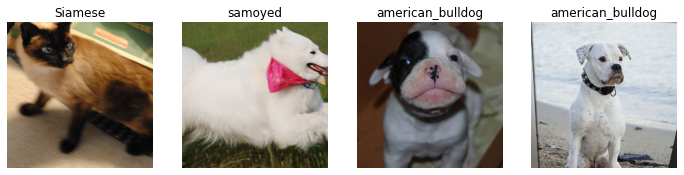

In [9]:
dls.show_batch(nrows=1, ncols=4)

## Model Training

In [10]:
learn = cnn_learner(dls, resnet50, 
                    loss_func=BCEWithLogitsLossFlat(), 
                    metrics=partial(accuracy_multi, thresh=0.95)).to_fp16()

SuggestedLRs(valley=0.001737800776027143)

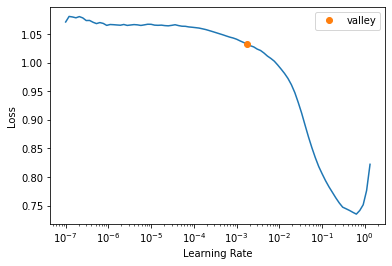

In [11]:
learn.lr_find()

In [12]:
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.614542,0.097368,0.978605,02:11


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.071798,0.025939,0.983543,02:43
1,0.031455,0.012953,0.990199,02:43
2,0.017832,0.011091,0.991241,02:42


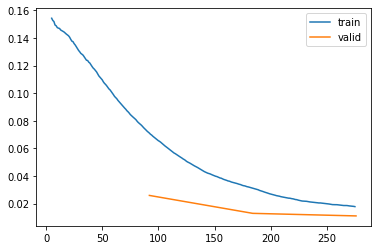

In [13]:
learn.recorder.plot_loss()

## Checking results

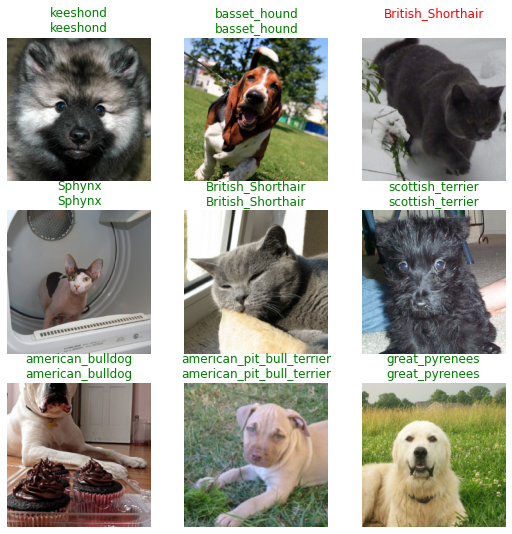

In [14]:
learn.show_results()

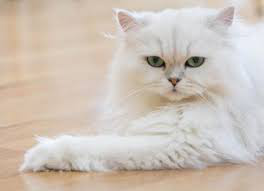

In [15]:
img = PILImage.create('persian.jpg')
img

In [16]:
learn.predict(img)[0]

(#1) ['Persian']

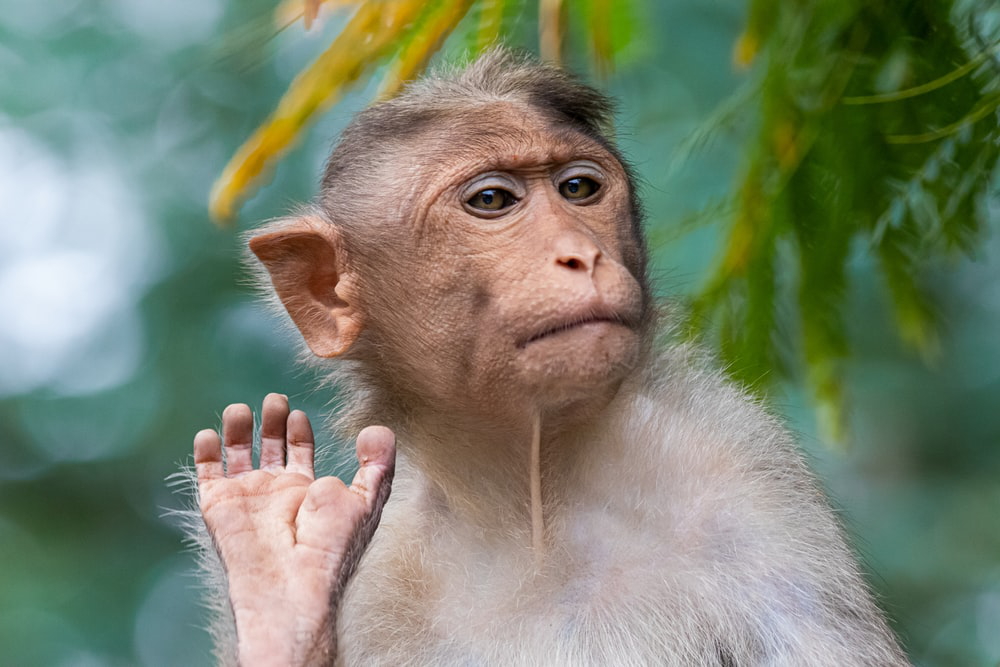

In [17]:
monkey = PILImage.create('monkey.jpg')
monkey

In [18]:
learn.predict(monkey)[0]

(#0) []

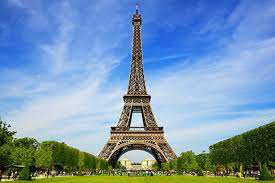

In [19]:
tower = PILImage.create('tower.jpg')
tower

In [20]:
learn.predict(tower)[0]

(#0) []